In [1]:
import torch
import clip
from PIL import Image

import os
import uuid

In [2]:
import gc

In [3]:
from dask import delayed, compute

In [4]:
import chromadb

In [5]:
from IPython.display import display
from IPython.display import Image as IPImage

In [6]:
from dask.distributed import Client
client = Client(
    memory_limit='5GiB',
    n_workers=4,
    threads_per_worker=1
)

In [9]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50417,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:50439,Total threads: 1
Dashboard: http://127.0.0.1:50443/status,Memory: 5.00 GiB
Nanny: tcp://127.0.0.1:50420,


In [10]:
def preprocess_image(preprocess, image_path, device):
    return preprocess(Image.open(image_path)).unsqueeze(0).to(device)

In [11]:
def embed_image(model, image):
    with torch.no_grad():
        return model.encode_image(image).cpu().numpy()

In [12]:
@delayed
def process_image(MODEL_NAME, image_path, device):
    model, preprocess = clip.load(MODEL_NAME, device=device)
    image = preprocess_image(preprocess, image_path, device)
    embedding = embed_image(model, image)
    id = str(uuid.uuid4())
    metadata = {"path": image_path}
    print(image_path, "embedded")
    del image
    del model
    del preprocess
    gc.collect()
    return embedding, id, metadata

In [13]:
def batch_image(dir_name, batch_size=48):
    batch_image_path = []
    for image_name in os.listdir(dir_name):
        if image_name.endswith('.jpg'):
            image_path = os.path.join(dir_name, image_name)
            batch_image_path.append(image_path)
            if len(batch_image_path) == batch_size:
                yield batch_image_path
                batch_image_path = []
    if batch_image_path:
        yield batch_image_path

In [14]:
def process_image_set(dir_name, MODEL_NAME, device, collection, batch_size=48):
    image_path_batches = batch_image(dir_name, batch_size=batch_size)
    for batch in image_path_batches:
        result = []
        for image_path in batch:
            result.append(process_image(MODEL_NAME, image_path, device))
        results = compute(*result)
        image_embeddings, ids, metadatas = zip(*results)
        image_embedding_list = []
        for image_embedding in image_embeddings:
            image_embedding_list.append(image_embedding[0].tolist())
        ids = list(ids)
        metadatas = list(metadatas)
        print(batch_size, "images embedded")

        collection.add(
            embeddings=image_embedding_list,
            metadatas=metadatas,
            ids=ids
        )
        del image_embedding_list
        del ids
        del metadatas
        gc.collect()
        print(batch_size, "embeddings insertion completed")

In [15]:
def search(input_text, model, device, collection, n_results=10):
    text = clip.tokenize(input_text).to(device)
    text_embedding = model.encode_text(text).tolist()
    hits = collection.query(
        query_embeddings=text_embedding,
        n_results=n_results
    )
    print("Input Text:")
    print(input_text)
    for path in hits["metadatas"][0]:
        print(path['path'])
        display(IPImage(path['path'], width=200))

In [16]:
DEVICE = "cpu"
MODEL_NAME = 'ViT-B/32'
DIR_NAME = "images/p7"

In [17]:
model, preprocess = clip.load(MODEL_NAME, device=DEVICE)

In [18]:
#dbclient = chromadb.PersistentClient(path="chromadb")
#run Chroma in client/server mode
#in command line, run:
#chroma run --path chromadb

In [19]:
dbclient = chromadb.HttpClient(host='localhost', port=8000)

In [20]:
collection = dbclient.get_or_create_collection(name="image_embeddings_db")

In [23]:
process_image_set(DIR_NAME, MODEL_NAME, DEVICE, collection, batch_size=48)

48 images embedded
48 embeddings insertion completed


In [28]:
input_text = "a boy and a girl"

Input Text:
a boy and a girl
images/p2\13648274.jpg


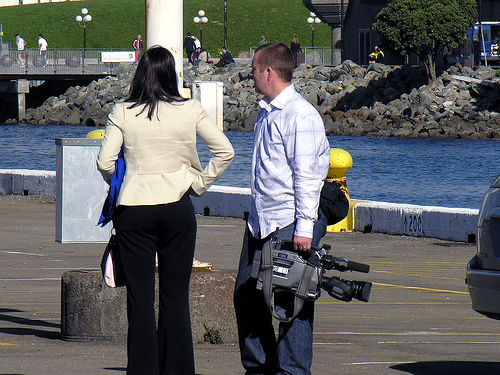

images/p1\4183120.jpg


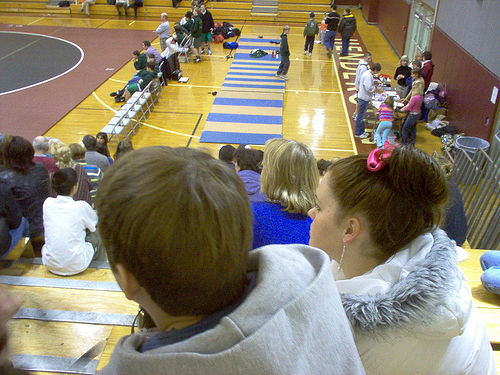

images/p2\16495609.jpg


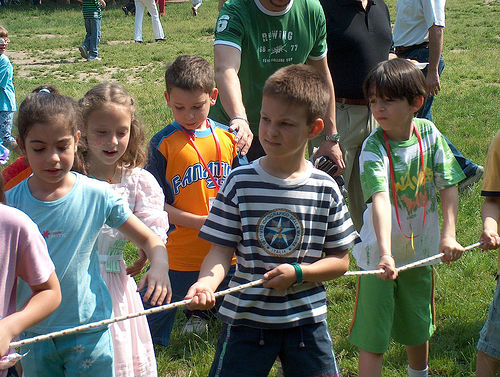

images/p1\205842.jpg


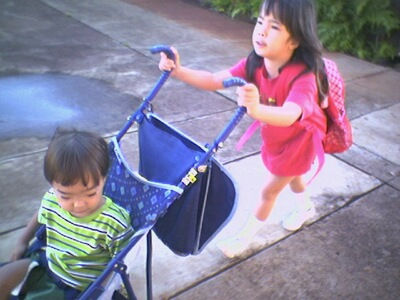

images/p5\120286774.jpg


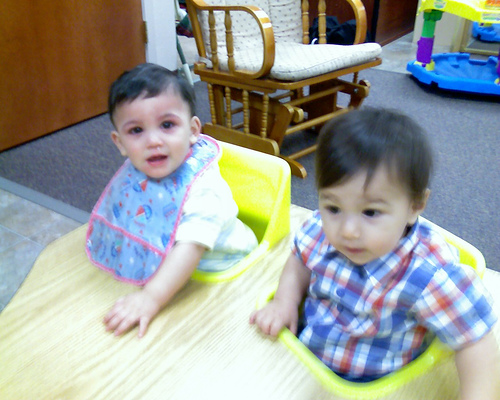

images/p3\27585638.jpg


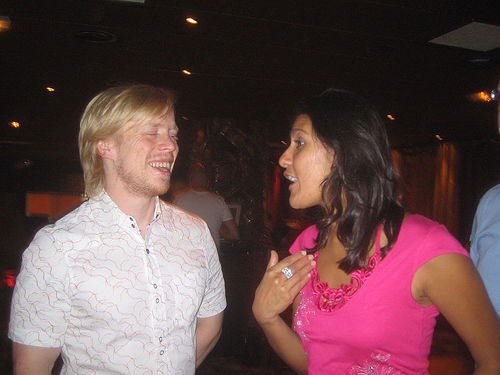

images/p3\33143954.jpg


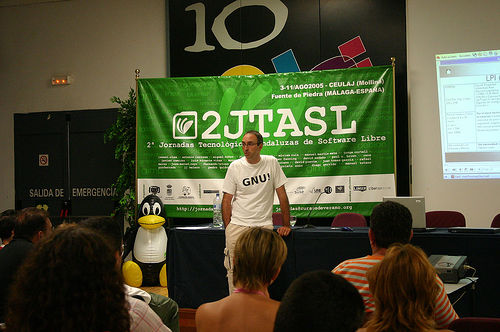

images/p3\23775702.jpg


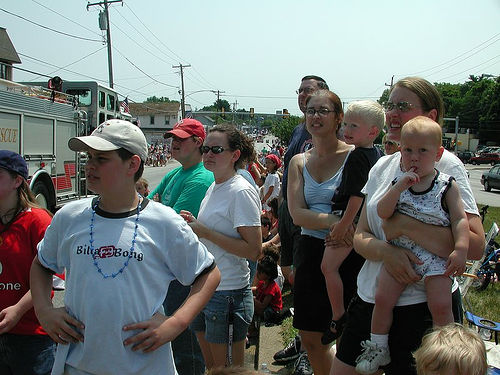

images/p1\9950913.jpg


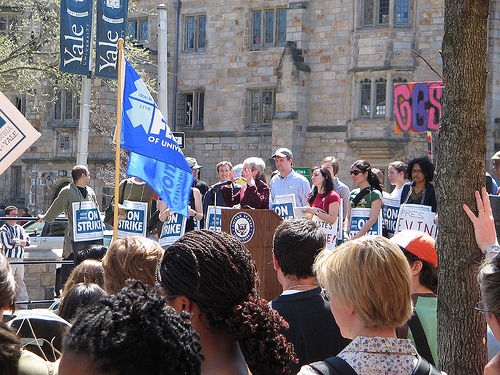

images/p1\2656351.jpg


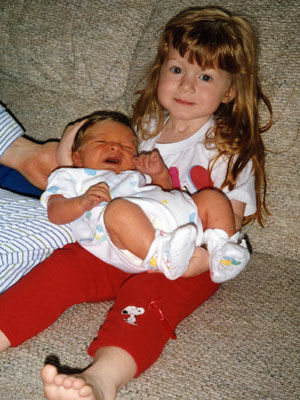

In [29]:
search(input_text, model, DEVICE, collection, n_results=10)

In [19]:
#delete the collection
dbclient.delete_collection(name="image_embeddings_db")